In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.model_selection import train_test_split
import re
import string
import time
import joblib
import bz2

In [2]:
# Get text and labels from raw file

def get_data(filepath):
    reviews = []
    text = []
    label = []
    with bz2.BZ2File(filepath,"r") as f:
        for line in f:
            x = line.decode()
            x = x.partition("_label__")
            reviews.append(x[2:])
        pass
    f.close()
    for review in reviews:
        label.append(review[0].split()[0])
        text.append(' '.join(review[0].split()[1:]))
        
    return text,label

In [3]:
# Create dataframe

def create_dataframe(filepath):
    text,label = get_data(filepath)
    data = {"text":text,"label":label}
    df = pd.DataFrame(data)
    print("Number of records:",len(df))
    df.dropna(inplace=True) # remove null records
    df.reset_index(drop=True,inplace=True)
    df["label"] = df["label"].astype(int)
    print("Number of records after removing nulls:",len(df))
    
    return df

## Create train dataframe


In [4]:
# Load train data

df = create_dataframe("train.ft.txt.bz2")

# Change labels to 0 and 1
df['label'] = df['label'].apply(lambda x: 0 if x==1 else 1)

df.head()

Number of records: 3600000
Number of records after removing nulls: 3600000


,text,label
0,Stuning even for the non-gamer: This sound tra...,1
1,The best soundtrack ever to anything.: I'm rea...,1
2,Amazing!: This soundtrack is my favorite music...,1
3,Excellent Soundtrack: I truly like this soundt...,1
4,"Remember, Pull Your Jaw Off The Floor After He...",1


In [5]:
df = df[:500000]

In [6]:
# Preprocessing function

def preprocess_text(data):
    # convert to string
    data = str(data)
    # convert to lowercase
    data = data.lower()
    # remove special characters
    data = re.sub(r'[^\w ]+','',data)
    # remove links
    data = re.sub(r'(http|https)?://\S+|www\.\S+','',data)
    # remove non-ascii
    data = ''.join(word for word in data if ord(word) < 128)
    # remove punctuation
    data = data.translate(str.maketrans('','',string.punctuation))
    # remove digits
    data = re.sub(r'[\d]+','',data)
    # remove single letters
    data = ' '.join(word for word in data.split() if len(word)>1)
    # remove multiple spaces
    data = ' '.join(data.split())
    
    return data

## Apply the pre-process function on the text column

In [7]:
# Apply preprocessing function to dataframe

df_copy = df.copy()
df_copy.loc[:,"text"] = df_copy["text"].apply(preprocess_text)
df_copy.head()

,text,label
0,stuning even for the nongamer this sound track...,1
1,the best soundtrack ever to anything im readin...,1
2,amazing this soundtrack is my favorite music o...,1
3,excellent soundtrack truly like this soundtrac...,1
4,remember pull your jaw off the floor after hea...,1


In [8]:
# Remove any null values post pre-processing
df_copy.dropna(inplace=True)
len(df_copy)

500000

In [9]:
# Label counts
df_copy['label'].value_counts()

1    252782
0    247218
Name: label, dtype: int64

## Train/Test split

In [10]:
# Split into train and dev sets

df_train,df_test = train_test_split(df_copy,
                                   test_size=0.2,
                                   stratify=df_copy["label"],
                                   random_state=42)

print("Train set size:",df_train.shape)
print("Dev set size:",df_test.shape)

Train set size: (400000, 2)
Dev set size: (100000, 2)


## Vectorize text using TfidfVectorizer

In [11]:
# Fit TfidfVectorizer

tfidf = TfidfVectorizer()
train_tfidf = tfidf.fit_transform(df_train["text"])
dev_tfidf = tfidf.transform(df_test["text"])

train_tfidf.shape,dev_tfidf.shape

((400000, 455560), (100000, 455560))

## Training Logistic Regression model

In [12]:
# Fit LogisticRegression model

labels = df_train['label']
lr = LogisticRegression(solver="lbfgs",max_iter=5000)
model_lr = lr.fit(train_tfidf,labels)

## Model predictions and metrics

In [13]:
# Test model on test set

predictions = model_lr.predict(dev_tfidf)

print("Accuracy for LR model:",accuracy_score(df_test["label"],list(predictions)))

Accuracy for LR model: 0.90369


In [14]:
print("\t\tClassification Report:\n\n",classification_report(df_test["label"],list(predictions)))

		Classification Report:

               precision    recall  f1-score   support

           0       0.90      0.90      0.90     49444
           1       0.90      0.91      0.90     50556

    accuracy                           0.90    100000
   macro avg       0.90      0.90      0.90    100000
weighted avg       0.90      0.90      0.90    100000



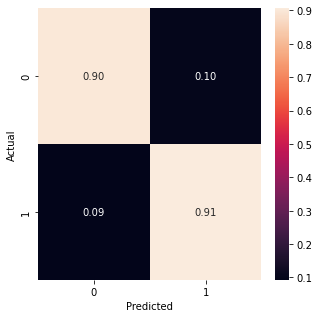

In [15]:
cm = confusion_matrix(df_test["label"],list(predictions),normalize='true')
df_cm = pd.DataFrame(cm)
fig = plt.figure(figsize=(5,5))
ax = sns.heatmap(df_cm,annot=True,fmt='.2f')
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
plt.show()